# CE 40719: Deep Learning
## HW6-Q5: REINFORCE (with baseline)

*Full name*: Mahdi Kafi

*STD-ID*: 99210753

In this notebook, you are going to implement REINFORCE algorithm on `CartPole-v0` and compare it to the case with a baseline. To know more about this, please refer to [Sutton&Barto, 13.3-13.4](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf). 

In [ ]:
%%bash
pip install gym pyvirtualdisplay > /dev/null 2>&1
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import gym
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Auxiliary methods

You can use the following methods to display demos and results of your code.

In [ ]:
root = '/content/video'
display = Display(visible=0, size=(200, 150))
display.start()

def show_video(path=root):
    mp4list = glob.glob(f'{path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 250px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env, path=root):
    return Monitor(env, path, force=True)

def plot_curves(curves, title, smooth=True, w_size=50):
    """
    This method plots series specified in `curves['series']`
    inside the same figure.

    - curves: a dictionary, dict(curves=a list of lists, labels=a list of strings);
    - title: figure's title;
    - smooth: whether to take a moving average over each series;
    - w_size: size of the moving average window;

    Notice: Series must have the same length.
    """
    series, labels = curves['series'], curves['labels']  
    N = len(series[0])
    assert all([len(s) == N for s in series])     
    x = list(range(N))
    for s, label in zip(series, labels):
        window = np.ones(w_size)/w_size
        s_smooth = np.convolve(s, window, mode='same')
        y = s_smooth[w_size:N-w_size] if smooth else s
        plt.plot(x[w_size:N-w_size], y, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

# `CartPole-v0`

You can see specifications of `CartPole-v0` in the following cell.

In [ ]:
env_id = 'CartPole-v0'
env = gym.make(env_id)
spec = gym.spec(env_id)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

Action Space: Discrete(2)
Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 195.0



Here you can see a demo of the completely random policy.

In [ ]:
env = gym.make('CartPole-v0')
env = wrap_env(env)
state = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
env.close()
show_video()

# Method

You can either use `Net` to create baseline and policy networks, or use any other custom architecture. 

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, outdim_policy, outdim_baseline):
        super(Net, self).__init__()
        self.shared = nn.Linear(input_dim, hidden_dim)
        self.policy = nn.Linear(hidden_dim, outdim_policy)
        self.baseline = nn.Linear(hidden_dim, outdim_baseline)

    def forward(self, x):
        x = self.shared(x)
        x = F.relu(x)
        p = F.softmax(self.policy(x))
        b = self.baseline(x)
        return p, b

In [ ]:
class REINFORCECartPole():
    def __init__(self, use_baseline=False, GAMMA=None, lr=None):
        self.env_id = 'CartPole-v0'
        self.env = gym.make(self.env_id)
        self.use_baseline = use_baseline
        self.GAMMA = GAMMA
        ############################ ToDo (1 points) #########################
        # Define your network, optimizer, and criterion.
        ######################################################################
        self.policy_net = Net(self.env.observation_space.shape[0], 128, self.env.action_space.n, 1).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.max_steps = 10_000
        self.loss_fn = nn.MSELoss()
        ######################################################################
    def generate_episode(self, video=False, train=True):
        trajectory = []
        ############################ ToDo (2 points) #########################
        # Generate a trajectory from the current policy. This method may be
        # used at training and evaluation time. Also you can record the demo
        # of the trajectory to display later.
        ######################################################################  
        if video: self.env = wrap_env(self.env)
        state = self.env.reset()
        done = False
        step_num = 0
        while not done and step_num < self.max_steps:
            # print(step_num)
            action, log_prob, state_val= self.select_action(state, train)
            new_state, reward, done, info = self.env.step(action)
            trajectory.append((state, action, reward, log_prob, state_val))
            state = new_state
            step_num += 1
        if video: self.env.close()
        # show_video()
        return trajectory


    def select_action(self, state, train=True):
        ############################ ToDo (4 points) #########################
        # Select action based on `state`. At training time, you should sample
        # from the policy distribution, but at test time, you need to takes
        # the best possible action.
        ######################################################################
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, state_val = self.policy_net(state)
        if train:
            highest_prob_action = np.random.choice(self.env.action_space.n, p=np.squeeze(probs.cpu().detach().numpy()))
        else:
            highest_prob_action = np.argmax(np.squeeze(probs.cpu().detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob, state_val



    def train(self, n_episodes, n_eval_episodes=15):
        ############################ ToDo (10 points) ########################
        # Train your networks in the following loop. At the end of each
        # episode, evaluate your networks on `n_eval_episodes` episodes and
        # store average total return of them in `TRs`. You are going to plot
        # these TRs later.
        ######################################################################
        TRs = []
        for i in tqdm(range(n_episodes)):
            trajectory = self.generate_episode()
            discounted_rewards = []
            for t in range(len(trajectory)):
                Gt = 0
                pw = 0
                for (s, a, r, lp, sv) in trajectory[t:]:
                    Gt += GAMMA**pw * r
                    pw += 1
                discounted_rewards.append(Gt)
            discounted_rewards = torch.tensor(discounted_rewards)
            # discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards
            #####################################################
            if self.use_baseline:
                # print("Using baseline")
                discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards
                state_vals = [sv for (s, a, r, lp, sv) in trajectory]
                state_vals = torch.tensor(state_vals)
                l = self.loss_fn(state_vals, discounted_rewards)
                deltas = [Gt - sv for Gt, sv in zip(discounted_rewards, state_vals)]
                deltas = torch.tensor(deltas)
                policy_gradient = []
                for d, (s, a, r, lp, sv) in zip(deltas, trajectory):
                    policy_gradient.append(-d*lp)
                self.optimizer.zero_grad()
                policy_gradient = torch.stack(policy_gradient).sum()
                total_loss = policy_gradient + l
                total_loss.backward()
                self.optimizer.step()
                TRs.append(self.evaluate(n_eval_episodes))
            else:
            #####################################################
                # print("Without using baseline")
                policy_gradient = []
                for (s, a, r, lp, sv), Gt in zip(trajectory, discounted_rewards):
                    policy_gradient.append(-lp*Gt)
                self.optimizer.zero_grad()
                policy_gradient = torch.stack(policy_gradient).sum()
                policy_gradient.backward()
                self.optimizer.step()
                TRs.append(self.evaluate(n_eval_episodes))
        return TRs


    def evaluate(self, n_episodes):
        ############################ ToDo (2 points) #########################
        # Evaluate your networks on `n_episodes` episodes and return the 
        # average **undiscounted** total return.
        ######################################################################
        total_rewards = []
        for episode in range(n_episodes):
            trajectory = self.generate_episode(train=False)
            rewards = []
            for t in range(len(trajectory)):
                Gt = 0
                for (s, a, r, lp, sv) in trajectory[t:]:
                    Gt += r
                rewards.append(Gt)
            total_rewards.append(sum(rewards))
        return sum(total_rewards)/len(total_rewards)

    def show_demo(self):
        ############################ ToDo (1 points) #########################
        # Display demo of one episode based on the current policy.
        ######################################################################
        self.generate_episode(video=True, train=False)
        show_video()

# Results & conclusion

In [ ]:
# First you need to choose appropriate input values.
n = 1000
lr = 3e-4
GAMMA = 0.9
kwargs = dict(GAMMA=GAMMA, lr=lr)

In [ ]:
reinforce = REINFORCECartPole(**kwargs)
returns_reinforce = reinforce.train(n)
reinforce.show_demo()

100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s]


In [ ]:
kwargs['use_baseline'] = True
reinforce_b = REINFORCECartPole(**kwargs)
returns_reinforce_b = reinforce_b.train(n)
reinforce_b.show_demo()

100%|██████████| 1000/1000 [15:15<00:00,  1.09it/s]


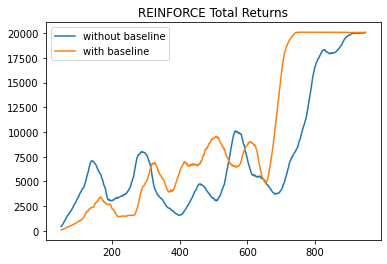

In [ ]:
############################ ToDo (1 points) ########################
# Plot total return curves for both methods in the same figure.
curves = {'series':[returns_reinforce, returns_reinforce_b], 'labels':['without baseline', 'with baseline']}
plot_curves(curves, title='REINFORCE Total Returns')
#####################################################################

**Question: (4 points)**

+ Interpret your results. What is the difference between REINFORCE with baseline and without baseline?

+ What is the difference between REINFORCE with baseline and Actor-Critic methods?

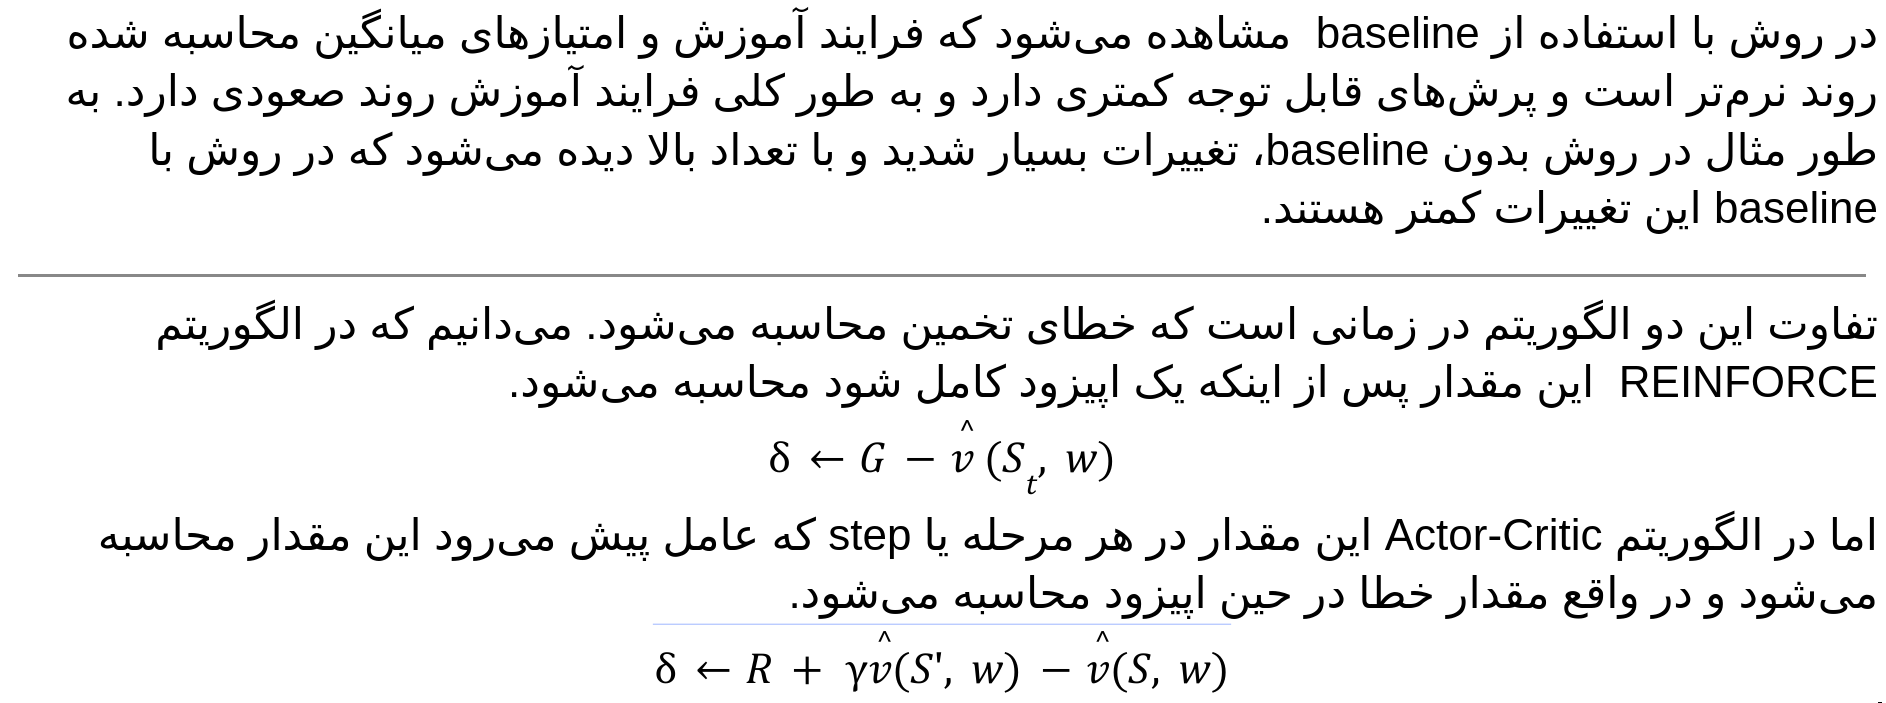